In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
from salishsea_tools import evaltools as et
import datetime as dt
import f90nml
import os
import glob
%matplotlib inline

In [2]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    print(fm.variables.keys())
    tmask=fm.variables['tmask'][:,:,:,:]
    z=fm.variables['gdept_1d'][:]
    e1e2t=fm.variables['e1t'][:,:,:]*fm.variables['e2t'][:,:,:]
    e2t=fm.variables['e2t'][:,:,:]
    umask=fm.variables['umask'][:,:,:,:]

dict_keys(['nav_lon', 'nav_lat', 'nav_lev', 'time_counter', 'tmask', 'umask', 'vmask', 'fmask', 'tmaskutil', 'umaskutil', 'vmaskutil', 'fmaskutil', 'glamt', 'glamu', 'glamv', 'glamf', 'gphit', 'gphiu', 'gphiv', 'gphif', 'e1t', 'e1u', 'e1v', 'e1f', 'e2t', 'e2u', 'e2v', 'e2f', 'ff', 'mbathy', 'misf', 'isfdraft', 'e3t_0', 'e3u_0', 'e3v_0', 'e3w_0', 'gdept_0', 'gdepu', 'gdepv', 'gdepw_0', 'gdept_1d', 'gdepw_1d', 'e3t_1d', 'e3w_1d'])


In [3]:
rpath='/data/eolson/results/MEOPAR/SS36runs/GrahamRuns/'
tdir='testT3TRP'

In [4]:
f0=nc.Dataset(glob.glob(os.path.join(rpath,tdir,'SalishSea_1h_*_ptrc_T_*.nc'))[0])
fe=nc.Dataset(glob.glob(os.path.join(rpath,tdir,'SalishSea_1h_*_pe3t_T_*.nc'))[0])
fu=nc.Dataset(glob.glob(os.path.join(rpath,tdir,'SalishSea_1h_*_grid_U_*.nc'))[0])

In [5]:
f0.variables.keys(), fe.variables.keys(), fu.variables.keys()

(dict_keys(['nav_lat_grid_T', 'nav_lon_grid_T', 'bounds_nav_lon_grid_T', 'bounds_nav_lat_grid_T', 'area_grid_T', 'deptht', 'deptht_bounds', 'nav_lat_grid_W', 'nav_lon_grid_W', 'bounds_nav_lon_grid_W', 'bounds_nav_lat_grid_W', 'area_grid_W', 'depthw', 'depthw_bounds', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'TUR1', 'TUR2', 'TUR3', 'TUR4', 'TUR5', 'TUR6', 'TUR7', 'TUR8', 'TUR9', 'TUR10', 'SFTURB', 'e3t', 'woce']),
 dict_keys(['nav_lat', 'nav_lon', 'bounds_nav_lon', 'bounds_nav_lat', 'area', 'deptht', 'deptht_bounds', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'TUR1_E3T', 'TUR2_E3T', 'TUR3_E3T', 'TUR4_E3T', 'TUR5_E3T', 'TUR6_E3T', 'TUR7_E3T', 'TUR8_E3T', 'TUR9_E3T', 'TUR10_E3T']),
 dict_keys(['nav_lat', 'nav_lon', 'bounds_nav_lon', 'bounds_nav_lat', 'area', 'deptht', 'deptht_bounds', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'TUR1_UT', 'TUR2_UT', 'TUR3_UT', 'TUR4_UT', 'TUR5_U

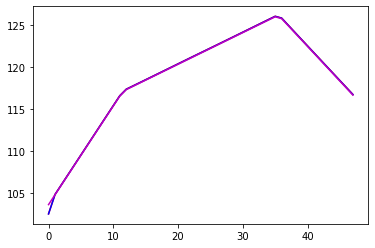

In [6]:
plt.plot(f0.variables['TUR1'][:,3,415,345],'r-')
plt.plot(f0.variables['TUR2'][:,3,415,345],'b-')
#plt.plot(f0.variables['woce'][:,3,415,345]*1e6,'g-')
plt.plot(f0.variables['SFTURB'][:,415,345],'m-')

In [7]:
np.max(np.abs(f0.variables['woce'][:,3,415,345]))

9.4697774e-05

In [8]:
nml=f90nml.read(os.path.join(rpath,tdir,'namelist_trace3_cfg'))
wd=nml['nampisriv']['wd']
alpha_C=nml['nampisriv']['alpha_C']
alpha_T=nml['nampisriv']['alpha_T']

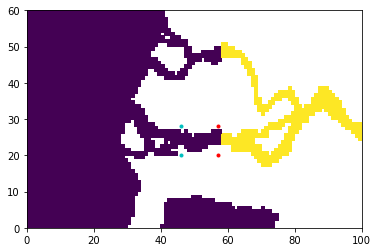

In [9]:
xw=(280,380)
yw=(390,450)
xl=(326,337)
yl=(410,418)
plt.pcolormesh(np.ma.masked_where(tmask[0,0,yw[0]:yw[1],xw[0]:xw[1]]==0,f0.variables['SFTURB'][-1,yw[0]:yw[1],xw[0]:xw[1]]))
plt.plot(xl[1]-xw[0],yl[1]-yw[0],'r.')
plt.plot(xl[0]-xw[0],yl[1]-yw[0],'c.')
plt.plot(xl[1]-xw[0],yl[0]-yw[0],'r.')
plt.plot(xl[0]-xw[0],yl[0]-yw[0],'c.')

In [10]:
vlist=[el for el in f0.variables.keys() if el.startswith('TUR')]
flen=np.shape(f0.variables[vlist[0]])[0]
maskTile=np.tile(tmask[:,:,yl[0]:yl[1],xl[0]:xl[1]],(flen,1,1,1))

In [11]:
sumT=dict()
ddt_sumT=dict()
sumW=dict()
sumE=dict()
bfluxest=dict()
resid=dict()
varturlist=('TUR1','TUR2','TUR3','TUR4','TUR5',
                         'TUR6','TUR7','TUR8','TUR9','TUR10')
vare3tlist=('TUR1_E3T','TUR2_E3T','TUR3_E3T','TUR4_E3T','TUR5_E3T',
                         'TUR6_E3T','TUR7_E3T','TUR8_E3T','TUR9_E3T','TUR10_E3T')
varulist=('TUR1_UT','TUR2_UT','TUR3_UT','TUR4_UT','TUR5_UT',
                         'TUR6_UT','TUR7_UT','TUR8_UT','TUR9_UT','TUR10_UT')
for i, vart,vare,varU in zip(np.arange(0,10),varturlist,vare3tlist,varulist):
    turvol=fe.variables[vare][:,:,yl[0]:yl[1],xl[0]:xl[1]]*e1e2t[:,yl[0]:yl[1],xl[0]:xl[1]]
    sumT[i]=np.sum(np.sum(np.sum(maskTile*turvol,3),2),1)
    ddt_sumT[i]=sumT[i][1:]-sumT[i][:-1] # per hour
    usliceW=fu.variables[varU][:,:,yl[0]:yl[1],xl[0]-1]*umask[:,:,yl[0]:yl[1],xl[0]-1]
    usliceE=fu.variables[varU][:,:,yl[0]:yl[1],xl[1]-1]*umask[:,:,yl[0]:yl[1],xl[1]-1]
    sumW[i]=np.sum(np.sum(usliceW,2),1)*3600 # per hour
    sumE[i]=np.sum(np.sum(usliceE,2),1)*3600 # per hour
    Cbot=np.sum(f0.variables[vart][:,:-1,yl[0]:yl[1],xl[0]:xl[1]]*(maskTile[:,:-1,:,:]-maskTile[:,1:,:,:]),1)
    #e3tbot=np.sum(f0.variables['e3t'][:,:-1,yl[0]:yl[1],xl[0]:xl[1]]*(maskTile[:,:-1,:,:]-maskTile[:,1:,:,:]),1)
    bfluxest[i]=np.sum(np.sum(-1*wd[i]/24*Cbot*(1-alpha_T[i])*e1e2t[:,yl[0]:yl[1],xl[0]:xl[1]],2),1) # per hour
    resid[i]=sumE[i]-sumW[i]+bfluxest[i]


(6000000000.0, 9200000000.0)

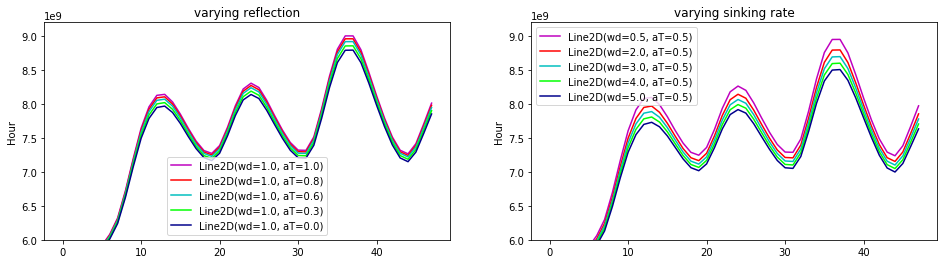

In [18]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
ax=ax.flatten()
cols=('m','r','c','lime','darkblue')
p=list()

for i in range(0,5):
    varind=i
    p1,=ax[0].plot(sumT[i],'-',color=cols[i],label='wd={}, aT={}'.format(wd[varind],alpha_T[varind]))
    p.append(p1)
ax[0].legend(p)
ax[0].set_title('varying reflection')
ax[0].set_ylabel('Tracer Content')
ax[0].set_ylabel('Hour')
ax[0].set_ylim(6e9,9.2e9)

p=list()
for i in range(5,10):
    varind=i
    p1,=ax[1].plot(sumT[i],'-',color=cols[i-5],label='wd={}, aT={}'.format(wd[varind],alpha_T[varind]))
    p.append(p1)
ax[1].legend(p)
ax[1].set_title('varying sinking rate')
ax[1].set_ylabel('Tracer Content')
ax[1].set_ylabel('Hour')
ax[1].set_ylim(6e9,9.2e9)

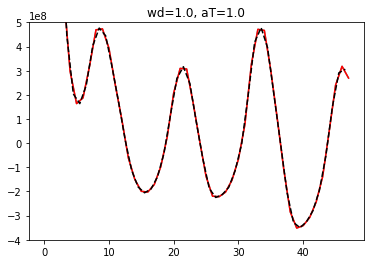

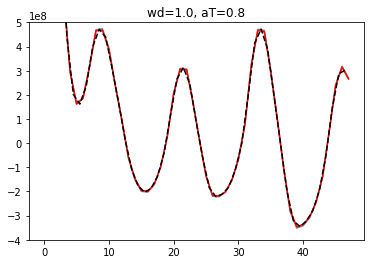

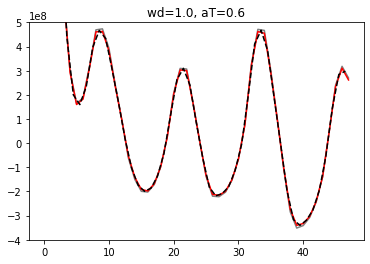

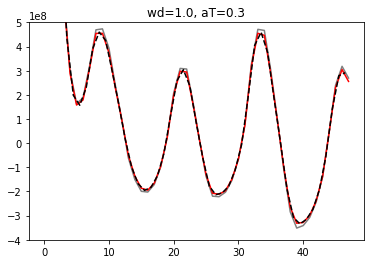

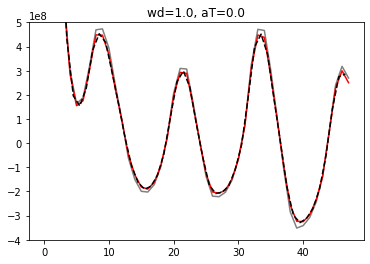

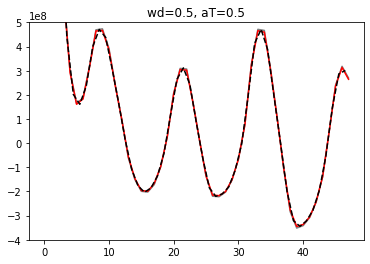

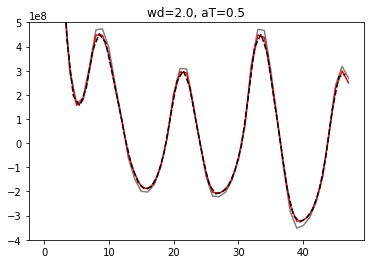

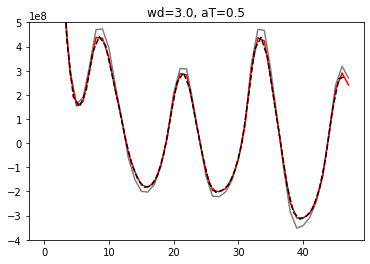

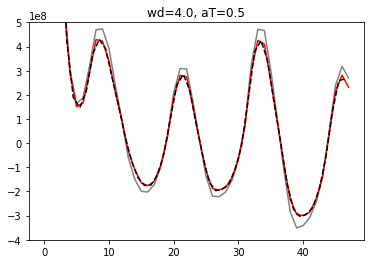

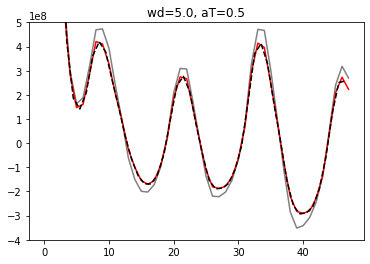

In [22]:
for ii in range(0,10):
    fig,ax=plt.subplots(1,1,figsize=(6,4))
    ax.plot(sumW[0]-sumE[0]+bfluxest[0],'-',color='gray')
    ax.plot(sumW[ii]-sumE[ii]+bfluxest[ii],'r-')
    ax.plot(np.arange(0.5,flen-1),ddt_sumT[ii],'k--')
    ax.set_title('wd={}, aT={}'.format(wd[ii],alpha_T[ii]))
    ax.set_ylim(-.4e9,.5e9)

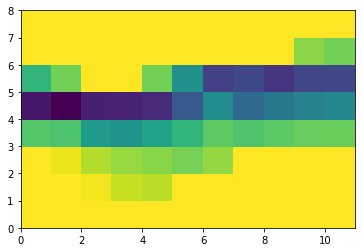

In [16]:
plt.pcolormesh(fu.variables['TUR1_UT'][5,2,yl[0]:yl[1],xl[0]:xl[1]])